# Franceschin CERIC beamtime @ SYRMEP Elettra
## Image processing of tomolab data

Created on:  03.03.2022 <br />
Last update: 03.03.2022 <br />

- Data courtesy of 

## Configuration

In [4]:
import os
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [5]:
%%html
<style>
table {float:left}
</style>

#### Load input data

In [6]:
input_file = '/home/gianthk/Data/BEATS/Franceschin/tomolab/tomo_Rec_crop/tomo__rec0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Beamline|TomoLab@Elettra|
|Sample|Roman glass|
|Energy| |
|Camera| |
|Voxel size|5.8 micron (?) |
|Preliminary operations|cropped|

In [7]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*5.8e-3 # [mm]

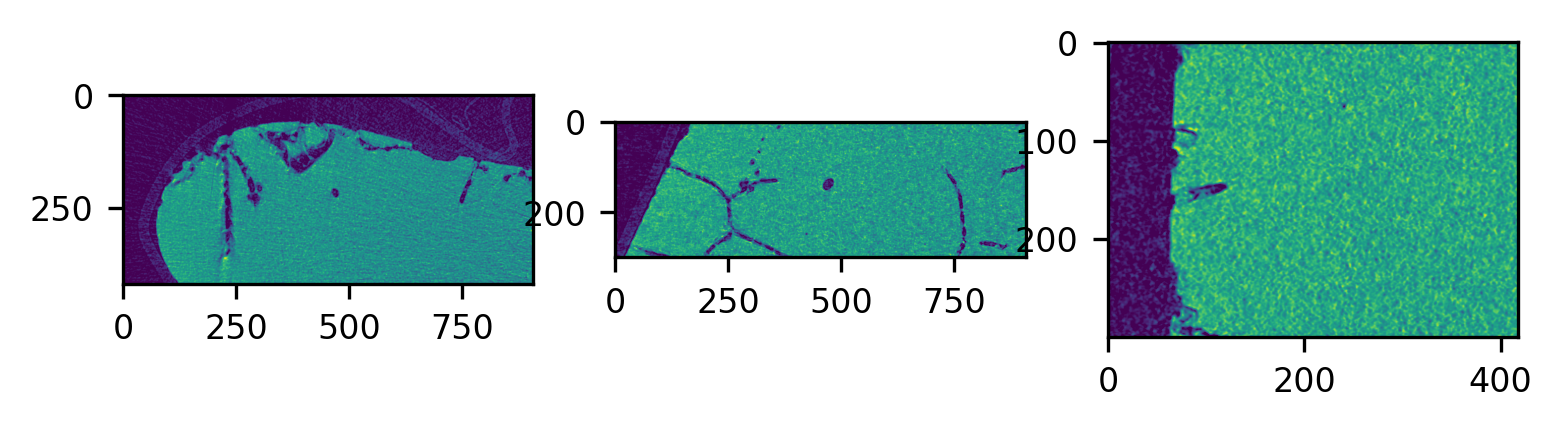

In [8]:
# Inspect dataset
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [6]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

## 1. Pre-processing
### 1.1. Gaussian smooth (optional)

In [8]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### 1.2. Resize (optional)

In [48]:
resampling = 1.2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [ ]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### 1.3. Thresholding

In [9]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 7036


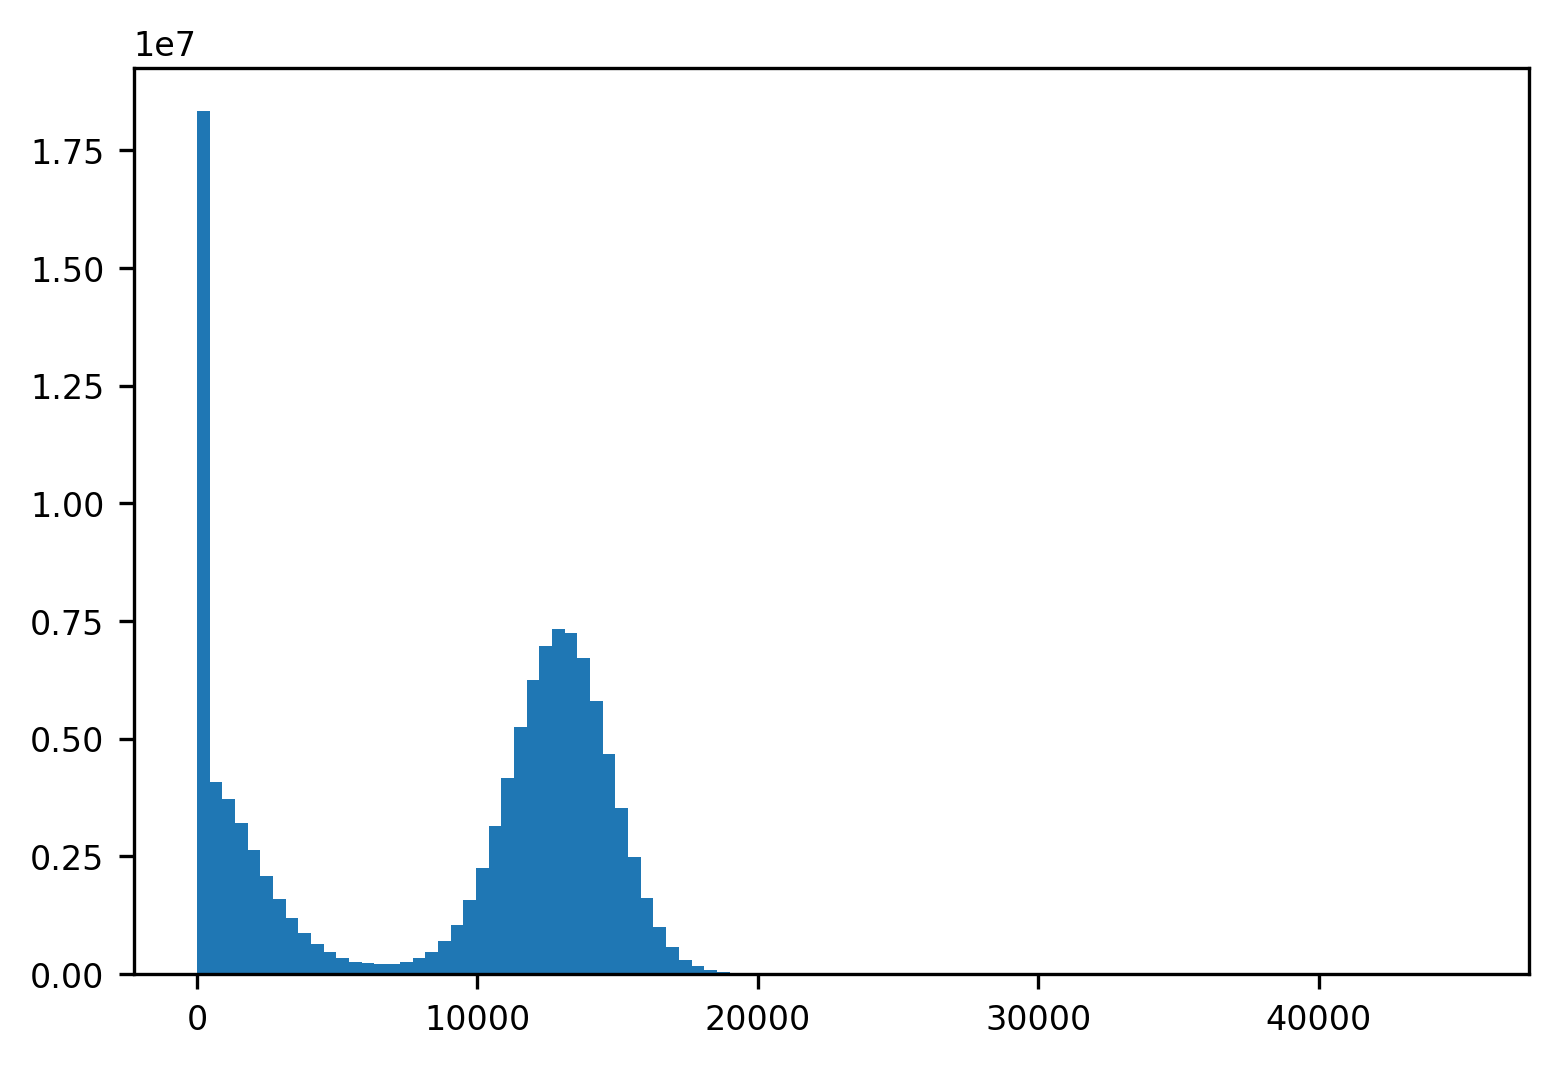

In [11]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=100)
plt.show()

In [12]:
# apply the threshold
# BW = data_3D > T
BW = data_3D > 7510

## 2. Sample boundary mask
### 2.1. remove holes

In [14]:
BWfill = ndimage.binary_fill_holes(BW)

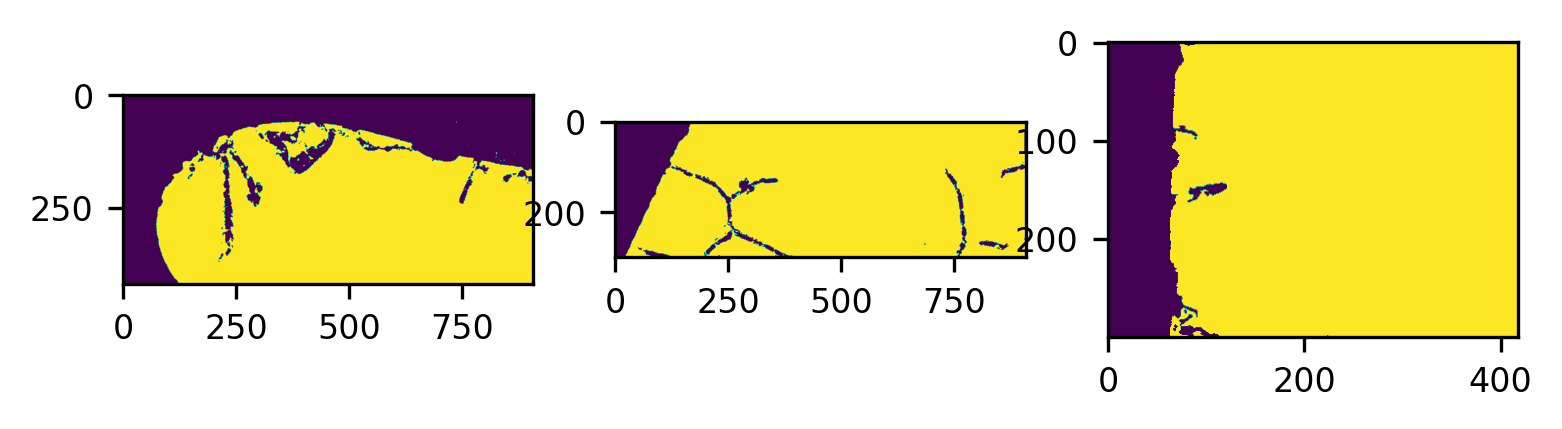

In [15]:
# Inspect dataset
plot_midplanes(BWfill)
plt.show()

### 2.2. remove unconnected objects

In [16]:
from pybonemorph import remove_unconnected 

In [18]:
BWfill = remove_unconnected(BWfill)

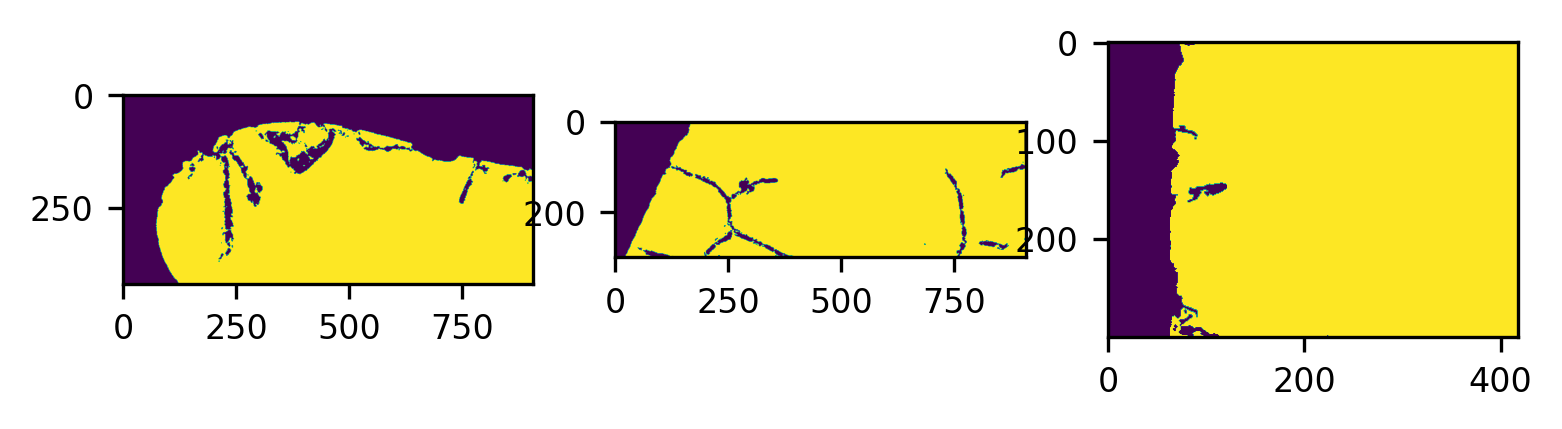

In [19]:
# Inspect dataset
plot_midplanes(BWfill)
plt.show()

### 2.3. Image close to fill the cracks

In [44]:
BW_close = morphology.closing(BWfill, morphology.cube(20))

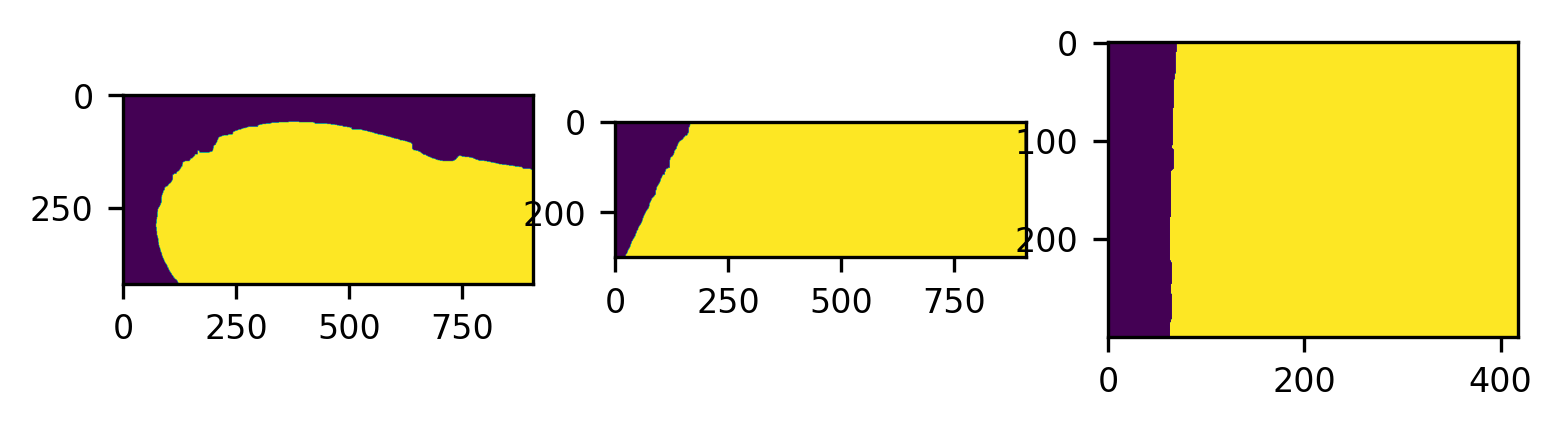

In [46]:
# Inspect dataset
plot_midplanes(BW_close)
plt.show()

Inspect with [napari](https://napari.org/)

In [ ]:
import napari
viewer = napari.view_image(BW_close)

### 2.4. outer sample boundary

In [48]:
BW_boudary = BW_close & ~morphology.erosion(BW_close)

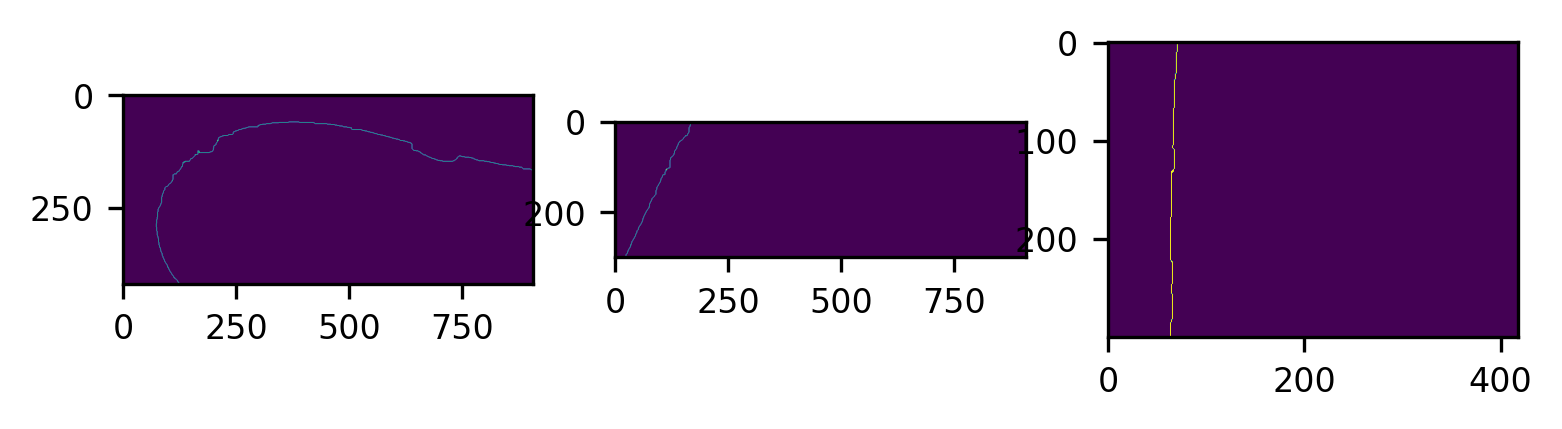

In [47]:
# Inspect dataset
plot_midplanes(BW_boudary)
plt.show()

## 3. analyzing cracks depth
### 3.1. distance transform from sample surface

In [51]:
dist = ndimage.distance_transform_edt(~BW_boudary)

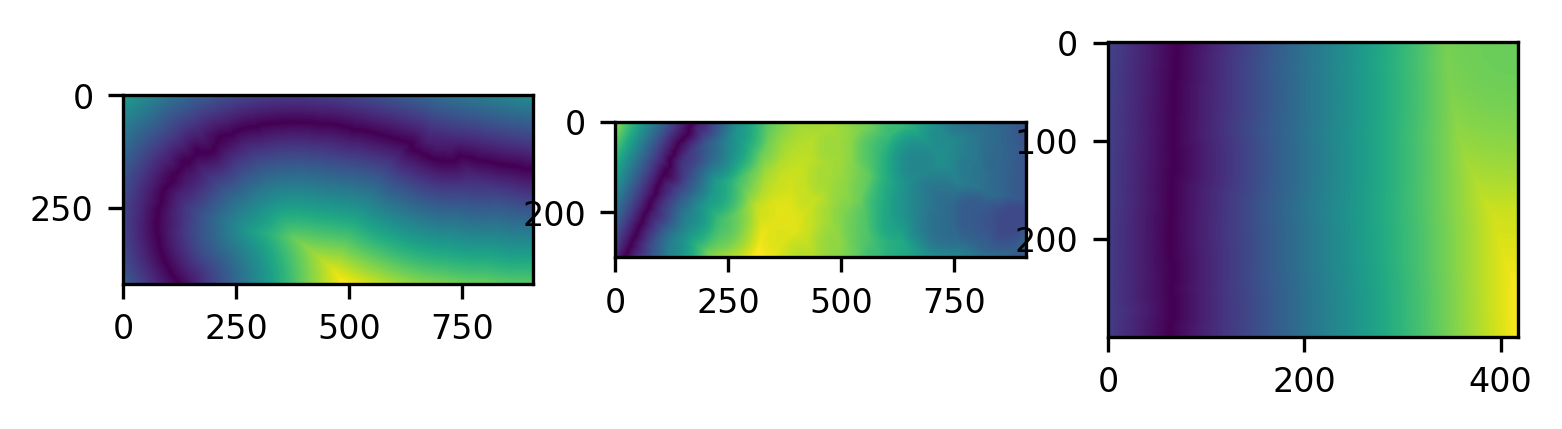

In [52]:
plot_midplanes(dist)
plt.show()

### 3.2. binary mask of the cracks

In [53]:
BW_cracks = BW_close & ~BW

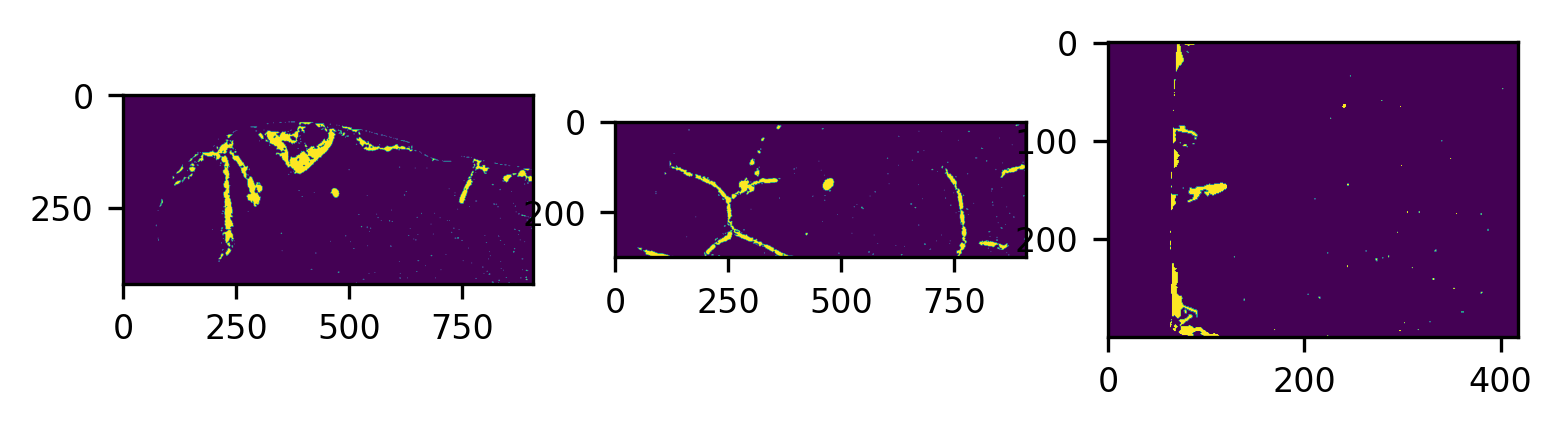

In [54]:
plot_midplanes(BW_cracks)
plt.show()

### 3.3. crack depth distribution

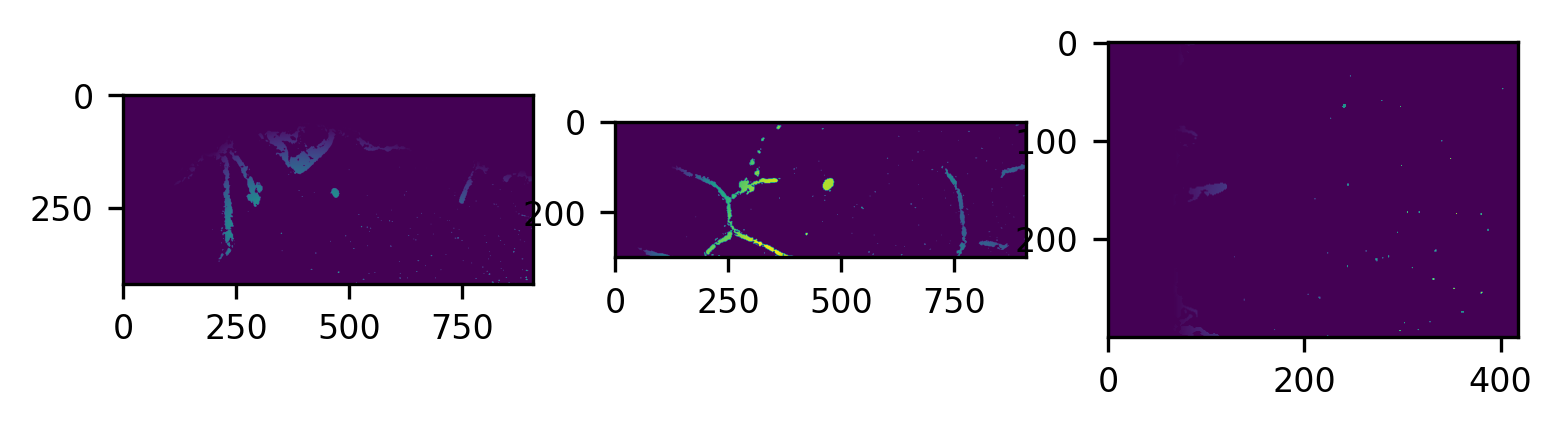

In [56]:
plot_midplanes(dist * BW_cracks)
plt.show()

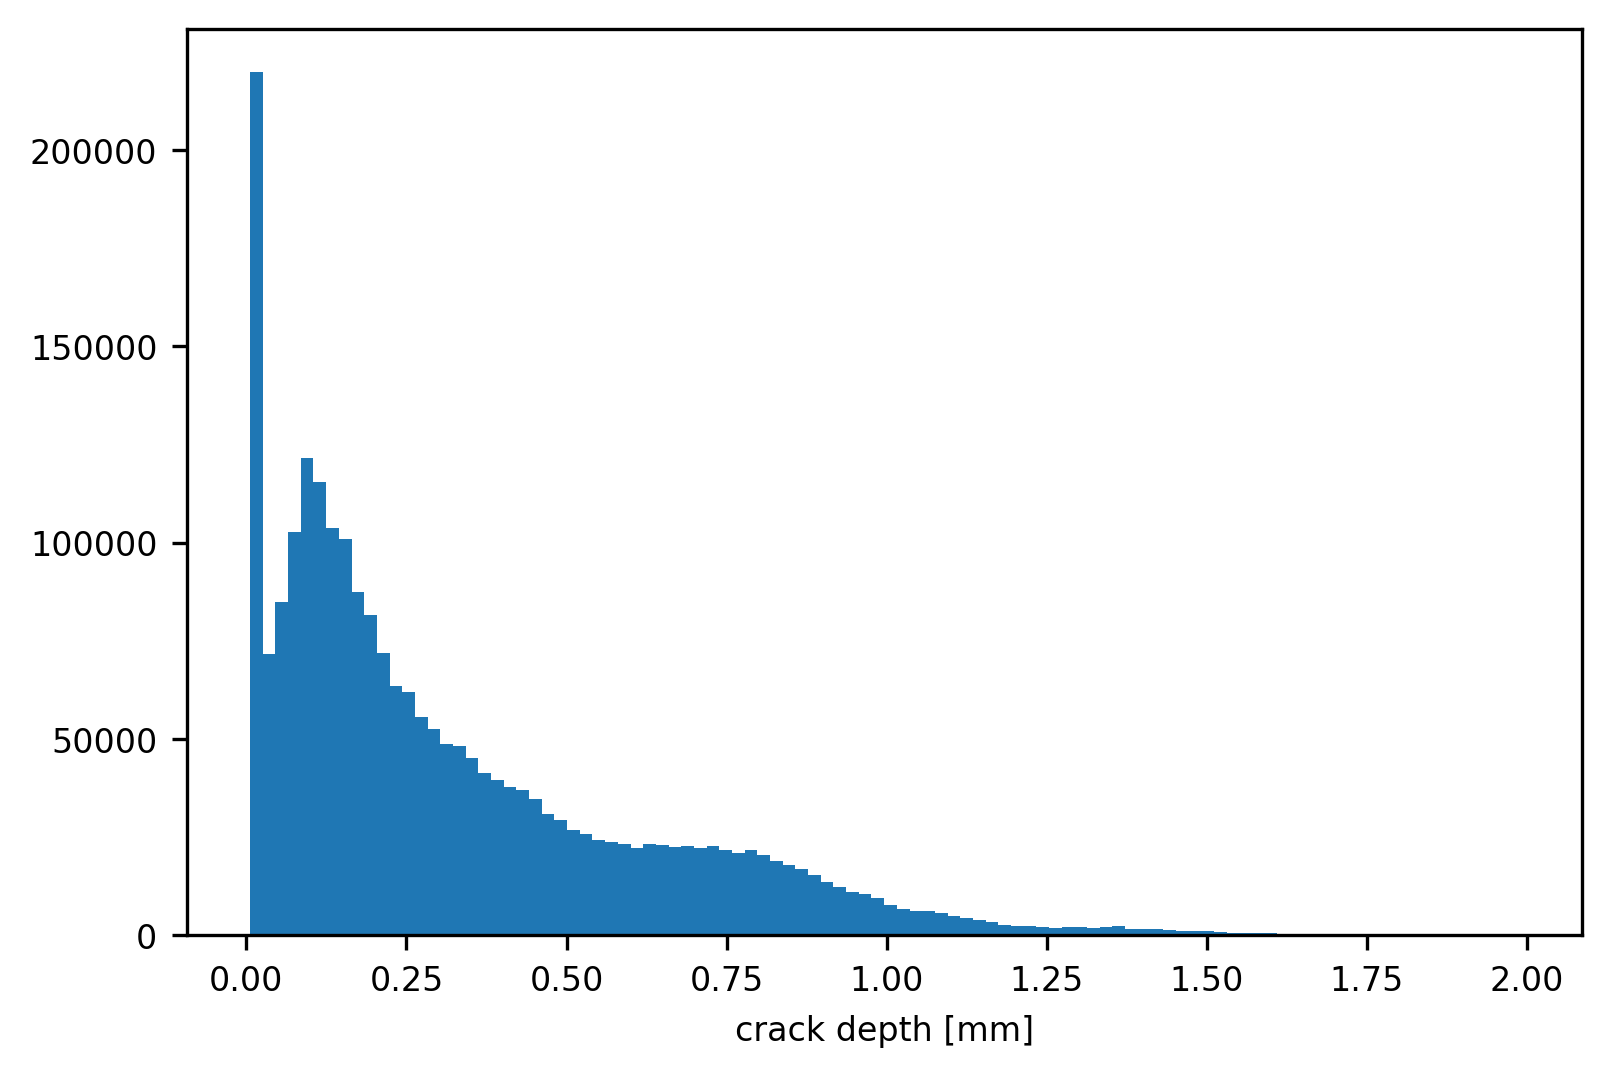

In [64]:
crack_dist = (dist * BW_cracks).ravel() * vs[0]
crack_dist[crack_dist == 0] = np.nan

fig2, ax2 = plt.subplots()
plt.hist(crack_dist, bins=100)
plt.xlabel('crack depth [mm]')
plt.show()